# Лабораторная работа №3

## Основное задание 
Реализуйте и исследуйте на эффективность SGD для решения линейной регрессии:

1. с разным размером батча – от одного до размера полной коллекции (обычный GD);

2. с разной функцией изменения шага (learning rate scheduling), например, экспоненциальной или ступенчатой.

3. scipy.optimize: SGD, и модификации SGD (Nesterov, Momentum, AdaGrad, RMSProp, Adam). Изучите параметры вызываемых библиотечных функций.

Сравните эффективность SGD с разными параметрами и его модификации по точности, скорости и ресурсам: объёму требуемой оперативной памяти и количеству арифметических операций. Иллюстрируйте примеры, чтобы не было скучно.

## Дополнительное задание 1
Реализуйте и исследуйте на эффективность SGD для полиномиальной регрессии с добавлением регуляризации в модель разных методов регуляризации (L1, L2, Elastic регуляризации).

## Дополнительное задание 2
Разберите подробней постановку задачи оптимизации в одной из задач машинного обучения (метод опорных векторов, активное обучение, бустинг и пр.). Приведите пример, иллюстрирующий задачу и её решение (найдите на ресурсах).

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage
from line_profiler import LineProfiler
from sklearn.metrics import mean_squared_error, r2_score

In [93]:
class SGD:
    def __init__(self, name, lr=0.01, epochs=1000, batch_size=32, tol=1e-3, lr_schedule=None):
        self.name = name
        self.initial_lr = lr
        self.learning_rate = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.tolerance = tol
        self.lr_schedule = lr_schedule
        self.weights = None
        self.bias = None
        self.losses = []  # Для хранения значений функции потерь
        self.time = None
    
    def reset(self):
        self.weights = None
        self.bias = None
        self.time = None
        self.losses = []

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def gradient(self, X_batch, y_batch):
        y_pred = self.predict(X_batch)
        error = y_pred - y_batch
        gradient_weights = np.dot(X_batch.T, error) / X_batch.shape[0]
        gradient_bias = np.mean(error)
        return gradient_weights, gradient_bias

    def fit(self, X, y):
        self.reset()
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()

        start_time = time.time()

        for epoch in range(self.epochs):
            # Update learning rate based on the schedule if provided
            if self.lr_schedule:
                self.learning_rate = self.lr_schedule(self.initial_lr, epoch)

            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                gradient_weights, gradient_bias = self.gradient(X_batch, y_batch)
                self.weights -= self.learning_rate * gradient_weights
                self.bias -= self.learning_rate * gradient_bias

            y_pred = self.predict(X)
            loss = self.mean_squared_error(y, y_pred)
            self.losses.append(loss)

            if np.linalg.norm(gradient_weights) < self.tolerance:
                print("Convergence reached.")
                break

        end_time = time.time()
        training_time = end_time - start_time

        self.time = training_time
        return self.weights, self.bias

    def plot_loss(self):
        plt.plot(self.losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss Over Epochs\n{self.name}')
        plt.show()

    def get_hyperparameters(self):
        return {
            'learning_rate': self.learning_rate,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'tolerance': self.tolerance,
            'lr_schedule': self.lr_schedule
        }

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

In [94]:
# Пример использования профилирования
def profile_fit(sgd, X, y):
    profiler = LineProfiler()
    profiler.add_function(sgd.fit)
    profiler.add_function(sgd.gradient)
    profiler.enable_by_count()
    sgd.fit(X, y)
    profiler.print_stats()

def measure_memory(sgd, X, y):
    mem_usage = memory_usage((sgd.fit, (X, y)), interval=0.1, retval=True)
    max_memory = max(mem_usage[0])  # mem_usage[0] содержит массив значений памяти
    return max_memory, mem_usage[1][0]  # возвращает максимальное использование памяти и время тренировки

# Датасеты

In [95]:
rand_1_X = np.random.randn(100, 5)
rand_1_y = np.dot(rand_1_X, np.array([1, 2, 3, 4, 5])) \
           + np.random.randn(100) * 0.1

test_1_X = np.random.randn(200, 5)
test_1_Y = np.random.randn(200)

In [96]:
rand_2_X = np.random.randn(1000, 10)
rand_2_y = np.dot(rand_2_X, np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])) \
           + np.random.randn(1000) * 0.1

test_2_X = np.random.randn(2000, 10)
test_2_Y = np.random.randn(2000)

In [97]:
train_datasets = [
    ["random train 1", rand_1_X, rand_1_y, "random test 1", test_1_X, test_1_Y],
    ["random train 2", rand_2_X, rand_2_y, "random test 2", test_2_X, test_2_Y],
]

In [98]:
def exponential_decay(initial_lr, epoch, decay_rate=0.01):
    return initial_lr * np.exp(-decay_rate * epoch)

def step_decay(initial_lr, epoch, drop=0.5, epochs_drop=50):
    return initial_lr * drop**(epoch // epochs_drop)

# Модели

In [99]:
sgd_exp_decay_bs16 = SGD(
    name="SGD with Exponential Decay and Batch Size 16",
    lr=0.01,
    epochs=1000,
    batch_size=16,
    tol=1e-3,
    lr_schedule=exponential_decay
)

In [100]:
sgd_exp_decay_bs32 = SGD(
    name="SGD with Exponential Decay and Batch Size 32",
    lr=0.01,
    epochs=1000,
    batch_size=32,
    tol=1e-3,
    lr_schedule=exponential_decay
)

In [101]:
sgd_exp_decay_bs64 = SGD(
    name="SGD with Exponential Decay and Batch Size 64",
    lr=0.01,
    epochs=1000,
    batch_size=64,
    tol=1e-3,
    lr_schedule=exponential_decay
)

In [102]:
sgd_step_decay_bs16 = SGD(
    name="SGD with Step Decay and Batch Size 16",
    lr=0.01,
    epochs=1000,
    batch_size=16,
    tol=1e-3,
    lr_schedule=step_decay
)

In [103]:
sgd_step_decay_bs32 = SGD(
    name="SGD with Step Decay and Batch Size 32",
    lr=0.01,
    epochs=1000,
    batch_size=32,
    tol=1e-3,
    lr_schedule=step_decay
)

In [104]:
sgd_step_decay_bs64 = SGD(
    name="SGD with Step Decay and Batch Size 64",
    lr=0.01,
    epochs=1000,
    batch_size=64,
    tol=1e-3,
    lr_schedule=step_decay
)

In [105]:
models = [sgd_exp_decay_bs16, sgd_exp_decay_bs32, sgd_exp_decay_bs64, sgd_step_decay_bs16, sgd_step_decay_bs32, sgd_step_decay_bs64]

In [106]:
# Глобальный DataFrame для хранения информации
global_results_df = pd.DataFrame(columns=["Model", "Train Data", "Test Data", "Training Time (s)", "Max Memory (MiB)", "MSE", "R^2"])

In [107]:
def log_model_performance(model, train_data_name, test_data_name, X_train, y_train, X_test, y_test):
    global global_results_df

    # Измерение использования памяти и времени обучения
    max_memory, training_time = measure_memory(model, X_train, y_train)

    # Оценка модели на тестовом наборе данных
    mse, r2 = model.evaluate(X_test, y_test)

    # Добавление результатов в DataFrame
    new_entry = pd.DataFrame({
        "Model": [model.name],
        "Train Data": [train_data_name],
        "Test Data": [test_data_name],
        "Training Time (s)": [model.time],
        "Max Memory (MiB)": [max_memory],
        "MSE": [mse],
        "R^2": [r2]
    })

    global_results_df = pd.concat([global_results_df, new_entry], ignore_index=True)


/var/folders/ns/3ydlw3_90wj1b6cr9x36trjr0000gn/T/ipykernel_71520/1038356553.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  global_results_df = pd.concat([global_results_df, new_entry], ignore_index=True)


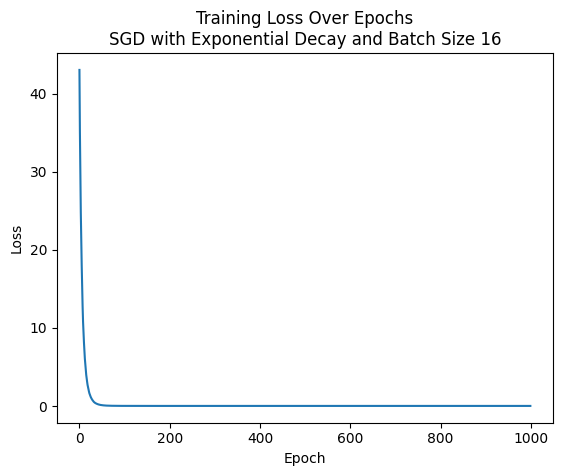

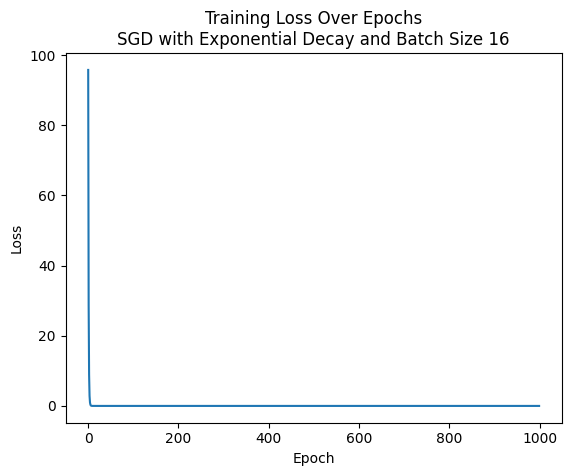

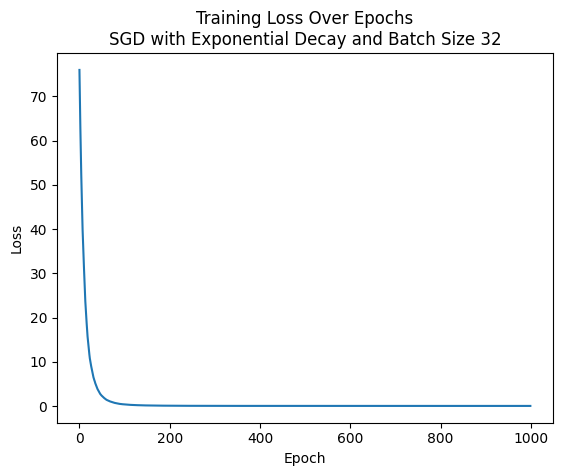

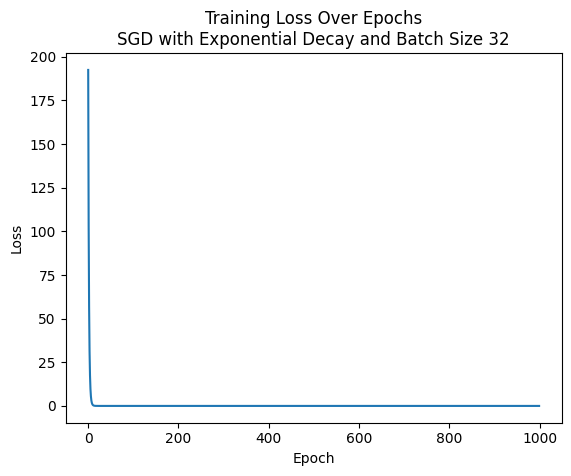

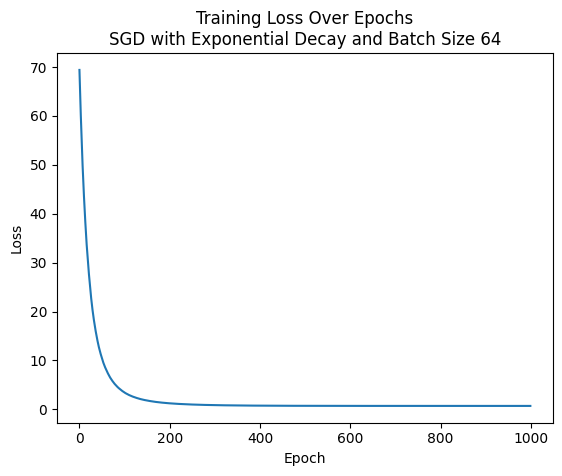

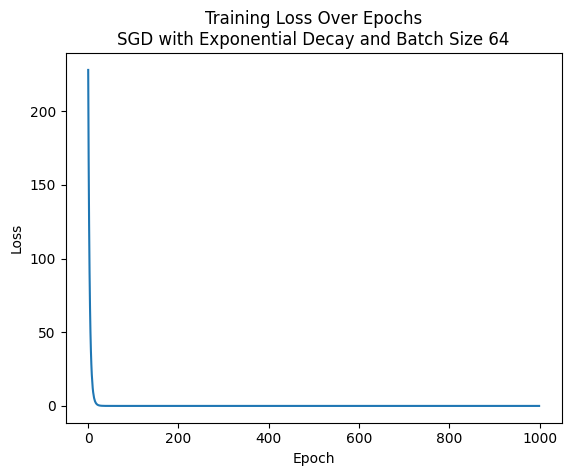

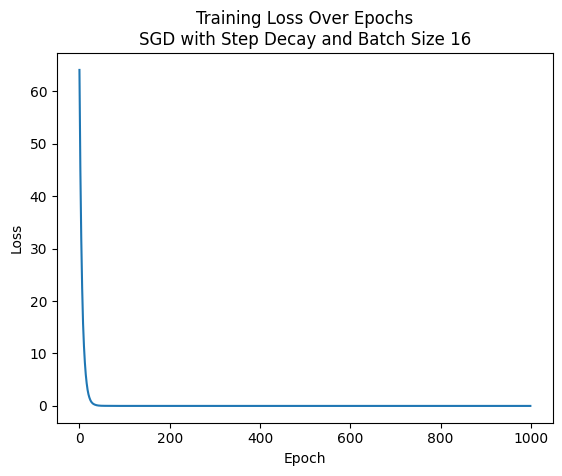

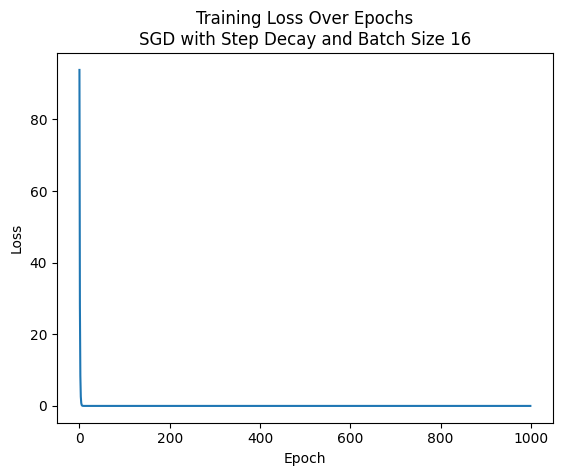

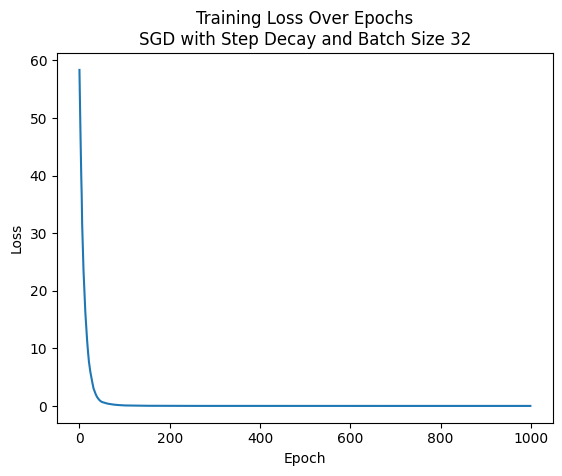

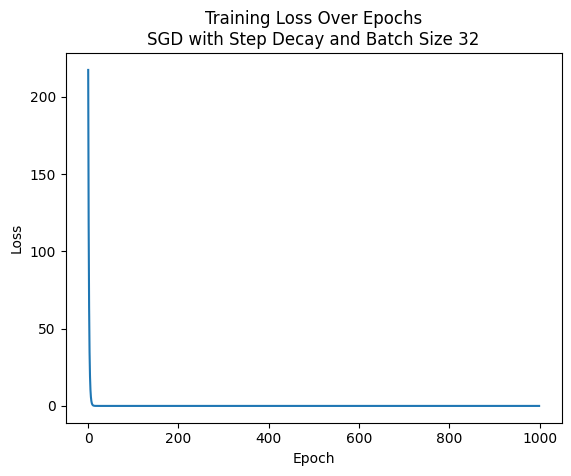

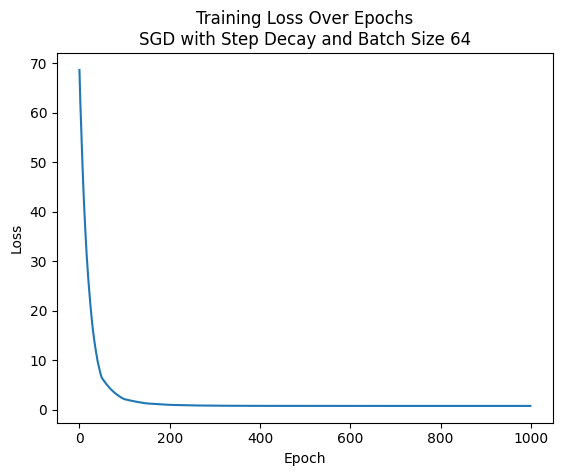

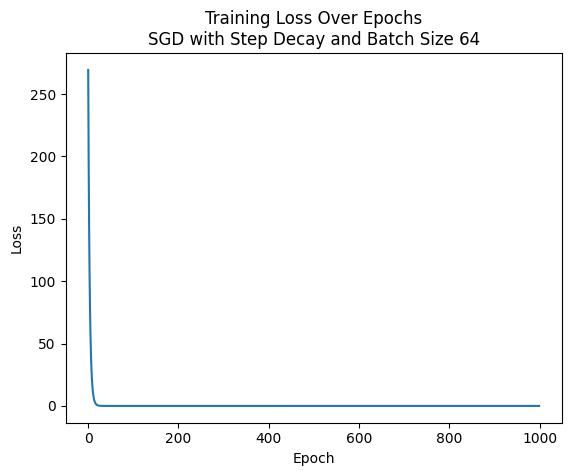

In [108]:
for model in models:
    for name_train, X_train, y_train, name_test, X_test, y_test in train_datasets:
        log_model_performance(model, name_train, name_test, X_train, y_train, X_test, y_test)
        model.plot_loss()

In [109]:
global_results_df

,Model,Train Data,Test Data,Training Time (s),Max Memory (MiB),MSE,R^2
0,SGD with Exponential Decay and Batch Size 16,random train 1,random test 1,0.081719,60.156250,59.390469,-67.380506
1,SGD with Exponential Decay and Batch Size 16,random train 2,random test 2,1.204888,90.578125,375.601068,-381.320476
2,SGD with Exponential Decay and Batch Size 32,random train 1,random test 1,0.054565,92.531250,57.506105,-65.210903
3,SGD with Exponential Decay and Batch Size 32,random train 2,random test 2,0.476218,97.015625,375.601704,-381.321124
4,SGD with Exponential Decay and Batch Size 64,random train 1,random test 1,0.036193,99.296875,47.940774,-54.197651
5,SGD with Exponential Decay and Batch Size 64,random train 2,random test 2,0.302215,101.484375,375.600573,-381.319972
6,SGD with Step Decay and Batch Size 16,random train 1,random test 1,0.081402,102.765625,59.370047,-67.356993
7,SGD with Step Decay and Batch Size 16,random train 2,random test 2,0.874852,105.812500,375.601553,-381.320970
8,SGD with Step Decay and Batch Size 32,random train 1,random test 1,0.054046,108.375000,57.849027,-65.605734
9,SGD with Step Decay and Batch Size 32,random train 2,random test 2,0.499514,106.250000,375.603789,-381.323246
